In [6]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from string import punctuation
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

In [7]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

# сразу убираем стоп-слова, чтобы неповадно было
stopwds = stopwords.words('russian') + stopwords.words('english')
punctuation = punctuation + '0123456789'
def clean(words):
    clean = [morph.parse(word.strip(punctuation))[0].normal_form for word in words if word not in stopwds and word.isalnum()]
    return clean

## Возьмем те же данные

In [8]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

In [9]:
# вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, common_terms=set(stopwords.words('russian')))
p = gensim.models.phrases.Phraser(ph)

In [14]:
p[habr_texts]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [15]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(p[habr_texts]):
    c = Counter(text)
    doc = 'doc_{} '.format(str(i))
    vw_text = ' '.join(['{}:{}'.format(x, str(c[x])) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [119]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [17]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [85]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [18]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [36]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df_rate=0.3)

artm.Dictionary(name=7cbdea40-7370-4c11-85bc-b9b8698e0045, num_entries=18377)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [37]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

In [128]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.35, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.35, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [129]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [130]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

### Тренируем модель

In [131]:
model_artm.num_document_passes = 6
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2)

Добавим регуляризаторы разреженности тем и документов.

In [132]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.20, 
                                                            topic_names=['topic_{}'.format(i) for i in range(3, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.20, 
                                                              topic_names=['topic_{}'.format(i) for i in range(3, 200)]))

In [133]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)

In [134]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.775 (ARTM)
Kernel contrast: 0.206 (ARTM)
Kernel purity: 0.190 (ARTM)
Perplexity: 1929.985 (ARTM)


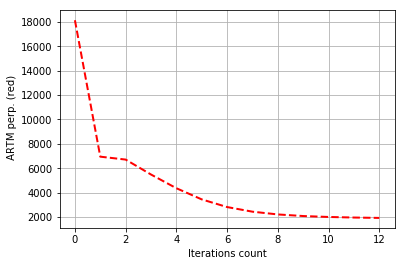

In [135]:
# посмотрим на качество
# это самая низкая перплексия, которой мне удалось добиться
print_measures(model_artm)

In [136]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    except KeyError:
        continue

topic_0: 
решиться
ура
монетизировать
шикарный
держать_рука
алиса
взлететь
забытый
мощный_инструмент
тайна
---------
topic_1: 
цензура
alliance
art
тема_доклад
south
фаервол
кругом
стилизация
di
горячее_клавиш
---------
topic_2: 
лекция
курс
профессор
озвучка
монтаж
обзорный
вступительный
django
эволюция
основный_направление
---------
topic_3: 
google
закон
суд
право
открытый
гражданин
яндекс
сша
юрист
заявить
---------
topic_4: 
ibm
изобретение
watson
компьютер
машина
ibm_watson
век
сша
мир
изобретатель
---------
topic_5: 
датчик
набор
мотор
комплект
сенсор
двигатель
деталь
ev
конструктор
элемент
---------
topic_6: 
рейтинг
беспроводный
стандарт
технология
передача
аудио
рынок
производитель
устройство
wireless
---------
topic_7: 
мониторинг
кэш
метрика
запрос
очередь
кэширование
memcached
ошибка
сервер
redis
---------
topic_8: 
gt
def
lt
print
b
c
f
import
val
key
---------
topic_9: 
книга
программа
компьютер
автор
идея
глава
программист
программирование
язык
развитие
---------
topic_

Меняла количество проходов по документу, выяснилось, что в каких-то пределах чем больше, тем лучше

Меняла количество проходов по коллекции до добавления регуляризаторов, 2=3, больше – хуже

Меняла входные tau у регуляризаторов, 0.35 у SmoothSparsePhiRegularizer лучше, чем 0.15 и 0.2, а для второго это не важно

А ещё по крайней мере в этих пятидесяти темах нет пустых –> параметры не перекручены

- что-то про код
```массив
элемент
позиция
строка
сортировка
блок
array
значение
алгоритм
ячейка
```
- что-то про магазины
```
скидка
магазин
покупка
цена
заказ
продавец
день
покупатель
акция
товар
```
- что-то про сети
```
адрес
маска
битый
подсеть
сеть
слот
класс
символ
хост
mask
```